## Imports

In [1]:
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import pearsonr

In [2]:
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
EUR_path_interval = "%s/genetic_score/EUR_interval" % export_folder
EUR_path = "%s/genetic_score/EUR" % export_folder
#tag = "26_nov"
tag = "20_dec_21"

In [3]:
betas_bolt_path = "%s/Genetic_score_Sysmex_traits/betas_BOLT.csv" % (export_folder)
bolt = pd.read_csv(betas_bolt_path,sep="\t")

## Read INTERVAL GWAS summary (hits only)

In [4]:
gwas_results = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table.csv",index_col=0)
gwas_results = gwas_results[["SNP","CHR","BP","ALLELE1","P","BETA","SE","SYMBOL"]].rename(columns={
    "BETA":"BETA_INTERVAL",
    "SE":"SE_INTERVAL",
    "P":"P_INTERVAL",
    "ALLELE1":"A1_INTERVAL"})
gwas_results.head(2)

,SNP,CHR,BP,A1_INTERVAL,P_INTERVAL,BETA_INTERVAL,SE_INTERVAL,SYMBOL
0,rs12566888,1,156869047,G,1.200000e-24,0.124800,0.012343,PEAR1
1,rs1434282,1,199010721,C,8.300000e-18,0.069544,0.008183,RP11-16L9.4


## Read PFC GWAS results (4 agonists, whole genotypes)

In [5]:
#agonist = "ADP_META"
agonists = ["ADP_META","CRP","PAR1","PAR4"]

pfcs = []
for ago in agonists:
    pfc = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/%s.tsv" % ago,sep="\t")
    pfc = pfc.sort_values("MLOG10P",ascending=False)
    pfc["agonist"] = ago
    pfc["hit_rank"] = np.arange(pfc.shape[0])
    pfcs.append(pfc)
pfc = pd.concat(pfcs,axis=0)

## Load full INTERVAL GWAS results

In [6]:
tag = "20_dec_21"
chr_group_files = glob("%s/%s/bolt_res_bgen_feb_ADP_pred_chr*" % (export_folder,tag))
bgs = []
for f in chr_group_files:
    df = pd.read_csv(f,sep="\t")
    assert df.isnull().sum(axis=0).sum() == 0
    bgs.append(df)
bg = pd.concat(bgs,axis=0).sort_values(["CHR","BP"])
#bg = bg.loc[bg.SNP.isin(gwas_results.SNP.tolist())]
bg.sample(3)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P_BOLT_LMM
152438,rs188676626,2,38989136,0,C,T,0.988255,0.859094,0.176956,0.67,0.015060,0.035515,0.179813,0.67,0.125571,0.72
957825,rs34698019,10,64067440,0,C,T,0.835004,0.945293,1.090670,0.30,-0.011032,0.009856,1.252760,0.26,1.035380,0.31
410118,rs541300579,2,119050493,0,T,A,0.966950,0.948504,0.348577,0.55,-0.012548,0.020325,0.381123,0.54,0.503220,0.48


In [7]:
litterature = [
    "rs185159562", # LINGO2 Keramati
    "rs575524466", # LRRC75A-AS1 Keramati
    "rs1207486385", # KCNJ18,UBBP4 Keramati
]

## Merge PFC and INTERVAL GWAS results

In [8]:
pfc = pd.merge(pfc, bg[["CHR","BP","SNP"]], left_on=["CHR","POS"],right_on=["CHR","BP"], how="left")
pfc.sample(3)
print(pfc.shape[0])
print((~pfc.SNP.isnull()).sum())
pfc.loc[pfc.SNP.isnull(),"SNP"] = pfc.loc[pfc.SNP.isnull(),"RSID"]

30689349
30165500


Missing for ADP_META = 
['rs3819288', 'rs59001897']
Missing for CRP = 
['rs3819288', 'rs59001897']
Missing for PAR1 = 
['rs3819288', 'rs59001897']
Missing for PAR4 = 
['rs3819288', 'rs59001897']


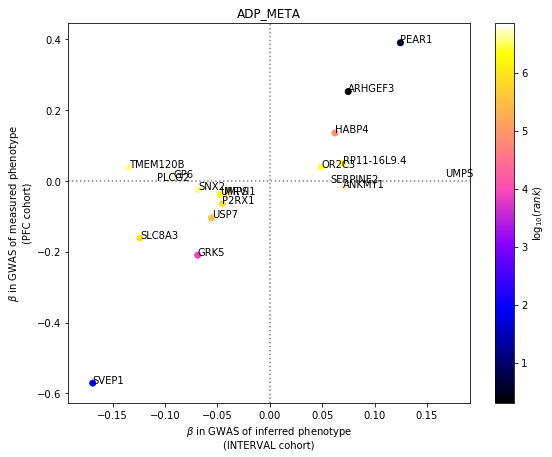

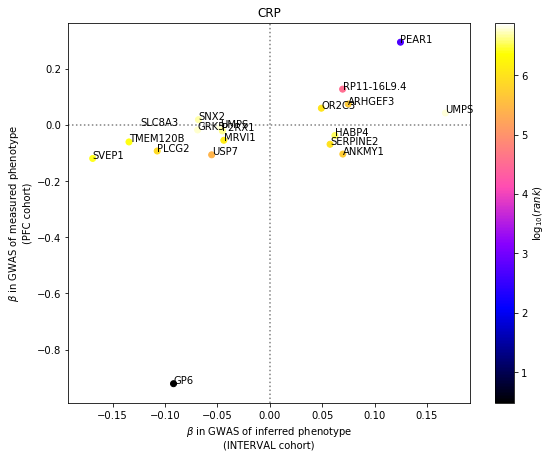

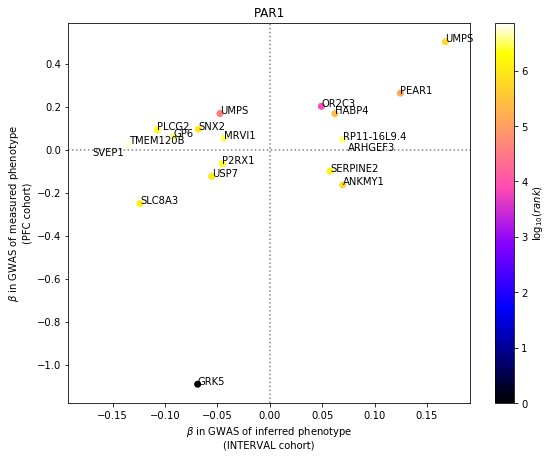

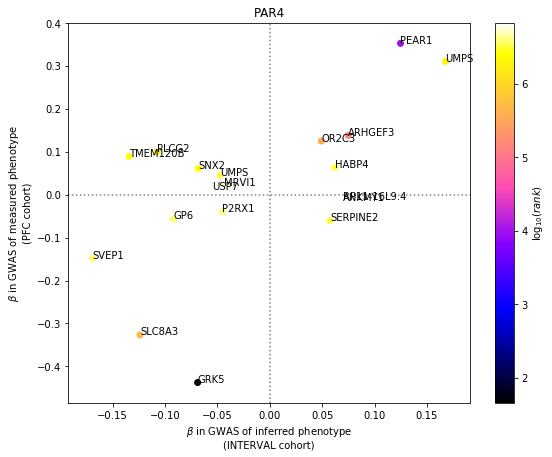

In [11]:
for ago in agonists:
    comp = pd.merge(bolt,pfc.loc[pfc.agonist == ago],how="inner",left_on="SNP",right_on="SNP")
    missing_SNPs = bolt.loc[~bolt.SNP.isin(comp.SNP.unique().tolist())].SNP.tolist()
    print("Missing for %s = " % ago)
    print(missing_SNPs)
    
    comp = pd.merge(comp, gwas_results[["SYMBOL","SNP","CHR"]], left_on="SNP",right_on="SNP")
    
    plt.figure(figsize=(9,7))
    plt.title(ago)
    cm = plt.scatter(comp["ADP_pred"],-comp["BETA"],c=np.log10(1.+comp["hit_rank"]),cmap="gnuplot2")
    for i, row in comp.iterrows():
        plt.text(row["ADP_pred"],-row["BETA"],row["SYMBOL"])
    plt.xlabel("$\\beta$ in GWAS of inferred phenotype\n(INTERVAL cohort)")
    plt.ylabel("$\\beta$ in GWAS of measured phenotype\n(PFC cohort)")
    plt.axvline(0,ls=':',c="grey")
    plt.axhline(0,ls=':',c="grey")
    plt.colorbar(cm,label="$\log_{10}(rank)$")

In [9]:
pfc_best_betas = pfc.sort_values("MLOG10P")\
    .groupby("ID").last()
pfc_best_betas = pfc_best_betas.add_suffix("_PFC")
pfc_best_betas = pfc_best_betas.rename(columns={"agonist_PFC":"best_agonist_PFC"})

In [10]:
pfc_best_betas.head()

,RSID_PFC,CHR_PFC,POS_PFC,REF_PFC,ALT_PFC,AAF_PFC,MINOR_PFC,MAF_PFC,ALT_MINOR_PFC,REF_COUNT_PFC,ALT_COUNT_PFC,INFO_PFC,BETA_PFC,SE_PFC,MLOG10P_PFC,best_agonist_PFC,hit_rank_PFC,BP_PFC,SNP_PFC
ID,,,,,,,,,,,,,,,,,,,
10:100000625_A_G,rs7899632,10,100000625,A,G,0.44200,G,0.44200,True,1533.35,1212.6500,0.9950,-0.02535,0.04007,0.2781,CRP,4068479,100000625.0,rs7899632
10:100000645_A_C,rs61875309,10,100000645,A,C,0.19960,C,0.19960,True,4395.80,1096.2000,0.9934,-0.05695,0.04957,0.6010,ADP_META,1913128,100000645.0,rs61875309
10:100001867_C_T,rs150203744,10,100001867,C,T,0.01316,T,0.01316,True,5419.70,72.3002,0.8023,-0.28830,0.19980,0.8271,ADP_META,1145198,100001867.0,rs150203744
10:100002464_T_C,rs111551711,10,100002464,T,C,0.01338,C,0.01338,True,5418.50,73.5004,0.7574,0.69770,0.21400,2.9540,ADP_META,9459,100002464.0,rs111551711
10:100003242_T_G,rs12258651,10,100003242,T,G,0.11900,G,0.11900,True,4838.50,653.5000,0.9904,0.13490,0.06337,1.4770,ADP_META,257308,100003242.0,rs12258651


In [11]:
# bb : best_betas
pfc_bb_bolt = pfc_best_betas.merge(
    gwas_results,
    left_on=["CHR_PFC","POS_PFC"],
    right_on=["CHR","BP"],
    how="right")
pfc_bb_bolt = pfc_bb_bolt.rename(
    columns={"SNP":"RSID_INTERVAL"})

In [12]:
rsid_is_dot = pfc_bb_bolt.RSID_PFC == "."
rsid_is_null = pfc_bb_bolt.RSID_PFC.isnull()
print("%d rsIDs are '.'" % rsid_is_dot.sum())
print("%d rsIDs are null" % rsid_is_null.sum())

2 rsIDs are '.'
2 rsIDs are null


In [13]:
missing_SNPs = pfc_bb_bolt.loc[rsid_is_null,"RSID_INTERVAL"].tolist()
print(missing_SNPs)

['rs3819288', 'rs59001897']


In [19]:
# Need to 
# 1) select SNPs in neighborhoods of missing SNPs
# 2) export genotypes to .bed format
# 3) use plink1.9 show-tags
n_splits = 32
for i, row in pfc_bb_bolt.loc[rsid_is_null].iterrows():
    SNP = row["SNP"]
    chrom = int(row["CHR"])
    snp_file = "/home/hv270/%s.txt" % SNP
    with open(snp_file,"w") as f:
        f.write(SNP)
    command = "/home/hv270/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --snp %s --window 500" % SNP
    command += " --make-bed"
    command += " --out %s/tag_snps_PFC_interval/%s_neighborhood" % (export_folder, SNP)
    
    tag = "TAG"
    f_name = "/home/hv270/interval_slurm_calls/call_tag_chr_%s_%s.sh" % (SNP,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (SNP))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=0:30:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("beta",tag,SNP))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (SNP))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

KeyError: 'SNP'

In [ ]:
# Remove duplicate SNPs
n_splits = 32
for i, row in pfc_bb_bolt.loc[rsid_is_null].iterrows():
    SNP = row["SNP"]
    chrom = int(row["CHR"])
    snp_file = "/home/hv270/%s.txt" % SNP
    with open(snp_file,"w") as f:
        f.write(SNP)
        
    command = "/home/hv270/plink2"
    command += " --bfile %s/tag_snps_PFC_interval/%s_neighborhood" % (export_folder, SNP)
    command += " --rm-dup force-first list"
    command += " --out %s/tag_snps_PFC_interval/%s_duplicates" % (export_folder, SNP)
    
    p = subprocess.Popen(command,shell=True)
    p.wait()

In [ ]:
replacement = {}

In [ ]:
# Find candidates
n_splits = 32
for i, row in pfc_bb_bolt.loc[rsid_is_null].iterrows():

    SNP = row["RSID_INTERVAL"]
    if SNP in replacement: continue
    chrom = int(row["CHR"])
    pfc_snps = pfc.loc[pfc.CHR == chrom].RSID.unique().tolist()
    print(len(pfc_snps))
    assert len(pfc_snps) > 0
    snp_file = "/home/hv270/%s.txt" % SNP
    with open(snp_file,"w") as f:
        f.write(SNP)
    r2_threshold = .95
    while r2_threshold > 0:

        command = "/home/hv270/plink"
        command += " --bfile %s/tag_snps_PFC_interval/%s_neighborhood" % (export_folder, SNP)
        command += " --exclude %s/tag_snps_PFC_interval/%s_duplicates.rmdup.list" % (export_folder, SNP)
        command += " --show-tags %s --tag-r2 %.2f" % (snp_file, r2_threshold)
        command += " --out %s/tag_snps_PFC_interval/%s_tags" % (export_folder, SNP)

        p = subprocess.Popen(command,shell=True)
        p.wait()
        
        cnd = open("%s/tag_snps_PFC_interval/%s_tags.tags" % (export_folder, SNP),"r").readlines()
        cnd = [f[:-1] for f in cnd]
        print("%d snps in LD at r^2 = %.2f, looking if they are in PFC GWAS results" % (len(cnd),r2_threshold))
        assert len(cnd) > 0
        if any([snp in pfc_snps for snp in cnd]):
            print("OK for %s at R^2 = %.2f" % (SNP,r2_threshold))
            for snp in cnd:
                if snp in pfc_snps:
                    replacement[SNP] = snp
                    break
            break
        else:
            print("No replacement for %s wiht R^2 = %.2f" % (SNP,r2_threshold))
            r2_threshold -= 0.05

In [ ]:
replacement

In [ ]:
replacement

In [39]:
n_splits = 12
tag = "replace"
for to_replace, substitute in replacement.items():
    
    chrom = int(pfc.loc[pfc.RSID == substitute].CHR.values[0])
    snp_file = "/home/hv270/%s.txt" % substitute
    with open(snp_file,"w") as f:
        f.write(substitute)
    
    gen_path = "%s/UKB_causal_SNPS_genotypes/chr_%d_replacement" % (export_folder, chrom)
    
    command = "/home/hv270/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --extract %s" % snp_file
    command += " --recode A-transpose --out %s" % gen_path
    
    f_name = "/home/hv270/interval_slurm_calls/call_beta_chr_%s_%s.sh" % (chrom,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=3:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("beta",tag,chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 6
Submitting 15


In [ ]:
# MAKE 

In [15]:
snp_path = "%s/conditional_analysis/causal_SNPs_BOLT_%s_%s.txt" % (export_folder,tag,"ADP_pred")

In [17]:
assert len(open(snp_path).readlines()) == bolt.shape[0]

In [18]:
export_folder

'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing'

In [19]:
n_splits = 12
for chrom in np.arange(1,23):
    gen_path = "%s/UKB_causal_SNPS_genotypes/chr_%d" % (export_folder, chrom)
    command = "/home/hv270/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --extract %s" % snp_path
    command += " --recode A-transpose --out %s" % gen_path
    
    f_name = "/home/hv270/interval_slurm_calls/call_beta_chr_%s_%s.sh" % (chrom,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=3:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("beta",tag,chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 4
Submitting 5
Submitting 6
Submitting 7
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 13
Submitting 14
Submitting 15
Submitting 16
Submitting 17
Submitting 18
Submitting 19
Submitting 20
Submitting 21
Submitting 22


## Read exports

### ... of INTERVAL SNPs

In [ ]:
dfs = []
for chrom in np.arange(1,23):
    gen_path = "%s/UKB_causal_SNPS_genotypes/chr_%d" % (export_folder, chrom)
    try:
        dfs.append(pd.read_csv(gen_path + ".traw",sep="\t"))
    except FileNotFoundError:
        pass
df = pd.concat(dfs,axis=0)

IDs_cols = [c for c in df.columns if "_" in c]

In [ ]:
dfs_rep = []
for chrom in np.arange(1,23):
    gen_path = "%s/UKB_causal_SNPS_genotypes/chr_%d_replacement" % (export_folder, chrom)
    try:
        dfs_rep.append(pd.read_csv(gen_path + ".traw",sep="\t"))
    except FileNotFoundError:
        pass

In [ ]:
df_rep = pd.concat(dfs_rep,axis=0)

In [ ]:
df.head(3)

In [ ]:
df_rep.head(3)

In [ ]:
df_all = pd.concat([df, df_rep], axis=0)

In [ ]:
G = df_all.set_index("SNP")[IDs_cols].T

In [ ]:
df_all.to_hdf("%s/df_all.hdf" % export_folder,key="df")
G.to_hdf("%s/G_UKBB.hdf" % export_folder,key="G")

## Read formatted genotypes

In [15]:
df_all = pd.read_hdf("%s/df_all.hdf" % export_folder)
G = pd.read_hdf("%s/G_UKBB.hdf" % export_folder)

In [94]:
# restart with the original PFC table, grouped by SNP
pfc = pfc_best_betas.copy()
# replacement = INTERVAL ONLY -> INTERVAL & PFC
replacement = {'rs3819288': 'rs17881225', 'rs59001897': 'rs12905925'}
interval_SNPs = bolt.SNP.unique().tolist() + [rep for tbr, rep in replacement.items()]
pfc_SNPs = [c for c in interval_SNPs if c not in replacement] + [rep for tbr, rep in replacement.items()]

In [95]:
len(set(pfc_SNPs))

21

In [96]:
len(set(interval_SNPs))

23

In [97]:
gwas_results.columns

Index(['SNP', 'CHR', 'BP', 'A1_INTERVAL', 'P_INTERVAL', 'BETA_INTERVAL',
       'SE_INTERVAL', 'SYMBOL'],
      dtype='object')

In [98]:
bg.columns

Index(['SNP', 'CHR', 'BP', 'GENPOS', 'ALLELE1', 'ALLELE0', 'A1FREQ', 'INFO',
       'CHISQ_LINREG', 'P_LINREG', 'BETA', 'SE', 'CHISQ_BOLT_LMM_INF',
       'P_BOLT_LMM_INF', 'CHISQ_BOLT_LMM', 'P_BOLT_LMM'],
      dtype='object')

In [99]:
# get rid of '.' rsIDs
pfc_good_rsIDs = pfc_best_betas.merge(
    bg.add_suffix("_INTERVAL"),
    left_on=["CHR_PFC","POS_PFC"],
    right_on=["CHR_INTERVAL","BP_INTERVAL"],
    how="outer")

In [100]:
pfc_good_rsIDs.SNP_INTERVAL.isin(interval_SNPs).sum()

23

In [101]:
pfc_good_rsIDs.loc[pfc_good_rsIDs.RSID_PFC == ".","RSID_PFC"] = \
    pfc_good_rsIDs.loc[pfc_good_rsIDs.RSID_PFC == ".","SNP_INTERVAL"]

In [102]:
mix = pfc_good_rsIDs.loc[pfc_good_rsIDs.SNP_INTERVAL.isin(interval_SNPs)].copy()

In [103]:
mix.shape

(23, 35)

In [104]:
mix[["RSID_PFC","CHR_PFC","POS_PFC","REF_PFC","ALT_PFC","SNP_INTERVAL","ALLELE1_INTERVAL"]].tail()

,RSID_PFC,CHR_PFC,POS_PFC,REF_PFC,ALT_PFC,SNP_INTERVAL,ALLELE1_INTERVAL
6403821,rs17881225,6.0,31323065.0,G,C,rs17881225,G
7584073,rs61751937,9.0,113312231.0,G,C,rs61751937,G
7873835,rs55665228,9.0,99234329.0,C,T,rs55665228,C
8758665,NaN,NaN,NaN,NaN,NaN,rs3819288,T
9783702,NaN,NaN,NaN,NaN,NaN,rs59001897,T


In [105]:
replacement_inv = {}
for key, value in replacement.items():
    replacement_inv[value] = key

In [106]:
mix["proxy_for"] = mix["SNP_INTERVAL"].replace(replacement_inv)

In [107]:
print(mix.shape[0])
mix[["RSID_PFC","CHR_PFC","POS_PFC","REF_PFC","ALT_PFC","SNP_INTERVAL","ALLELE1_INTERVAL","proxy_for"]].tail()

23


,RSID_PFC,CHR_PFC,POS_PFC,REF_PFC,ALT_PFC,SNP_INTERVAL,ALLELE1_INTERVAL,proxy_for
6403821,rs17881225,6.0,31323065.0,G,C,rs17881225,G,rs3819288
7584073,rs61751937,9.0,113312231.0,G,C,rs61751937,G,rs61751937
7873835,rs55665228,9.0,99234329.0,C,T,rs55665228,C,rs55665228
8758665,NaN,NaN,NaN,NaN,NaN,rs3819288,T,rs3819288
9783702,NaN,NaN,NaN,NaN,NaN,rs59001897,T,rs59001897


In [182]:
mix.columns

Index(['RSID_PFC', 'CHR_PFC', 'POS_PFC', 'REF_PFC', 'ALT_PFC', 'AAF_PFC',
       'MINOR_PFC', 'MAF_PFC', 'ALT_MINOR_PFC', 'REF_COUNT_PFC',
       'ALT_COUNT_PFC', 'INFO_PFC', 'BETA_PFC', 'SE_PFC', 'MLOG10P_PFC',
       'best_agonist_PFC', 'hit_rank_PFC', 'BP_PFC', 'SNP_PFC', 'SNP_INTERVAL',
       'CHR_INTERVAL', 'BP_INTERVAL', 'GENPOS_INTERVAL', 'ALLELE1_INTERVAL',
       'ALLELE0_INTERVAL', 'A1FREQ_INTERVAL', 'INFO_INTERVAL',
       'CHISQ_LINREG_INTERVAL', 'P_LINREG_INTERVAL', 'BETA_INTERVAL',
       'SE_INTERVAL', 'CHISQ_BOLT_LMM_INF_INTERVAL', 'P_BOLT_LMM_INF_INTERVAL',
       'CHISQ_BOLT_LMM_INTERVAL', 'P_BOLT_LMM_INTERVAL', 'proxy_for',
       'BETA_INTERVAL_PFC_convention', 'homogenous_BETA', 'homogenous_SE',
       'SNP', 'COUNTED_IN_UKB'],
      dtype='object')

In [108]:
mix = mix.loc[~mix.RSID_PFC.isnull()]

In [109]:
mix.sort_values(["CHR_PFC","POS_PFC"])[["RSID_PFC","ALT_PFC","ALLELE1_INTERVAL","proxy_for","BETA_PFC","BETA_INTERVAL"]]

,RSID_PFC,ALT_PFC,ALLELE1_INTERVAL,proxy_for,BETA_PFC,BETA_INTERVAL
2898696,rs12566888,T,G,rs12566888,-0.39070,0.124800
3030735,rs1434282,T,C,rs1434282,-0.12670,0.069544
3190309,rs41315846,C,T,rs41315846,-0.20240,0.049249
4176664,rs13412535,A,G,rs13412535,0.06930,0.057557
4235757,rs78909033,A,G,rs78909033,0.10420,0.069758
4896919,rs1354034,C,T,rs1354034,-0.25290,0.074894
4544905,rs13067286,A,G,rs13067286,-0.16860,-0.047616
4545082,rs76445378,T,C,rs76445378,-0.50330,0.167710
5679985,rs922140,G,A,rs922140,-0.09618,-0.068151
6403821,rs17881225,C,G,rs3819288,0.31080,0.082018


## Make effect sizes homogenous

In [110]:
mix["BETA_INTERVAL_PFC_convention"] = - mix["BETA_INTERVAL"]

In [111]:
from sklearn.linear_model import LinearRegression

mix["homogenous_BETA"] = 0.
mix["homogenous_SE"] = 0.

for ago in mix.best_agonist_PFC.unique().tolist():
    print(ago)
    cond = (mix.best_agonist_PFC == ago)
    lm = LinearRegression(fit_intercept=False).fit(mix.loc[cond,["BETA_PFC"]],mix.loc[cond,["BETA_INTERVAL_PFC_convention"]])
    mix.loc[cond,"homogenous_BETA"] = lm.predict(mix.loc[cond,["BETA_PFC"]])
    mix.loc[cond,"homogenous_SE"] = mix.loc[cond,["SE_PFC"]].values[:,0]*np.abs(lm.coef_[0,0])

PAR1
CRP
PAR4
ADP_META


In [112]:
mix = mix.merge(
    df_all[["SNP","COUNTED"]].rename(columns={"COUNTED":"COUNTED_IN_UKB"}),
    left_on="SNP_INTERVAL",right_on="SNP",how="left")
assert (mix["ALT_PFC"] != mix["ALLELE1_INTERVAL"]).all()
assert (mix["ALT_PFC"] == mix["COUNTED_IN_UKB"]).all()

In [113]:
mix.shape

(21, 41)

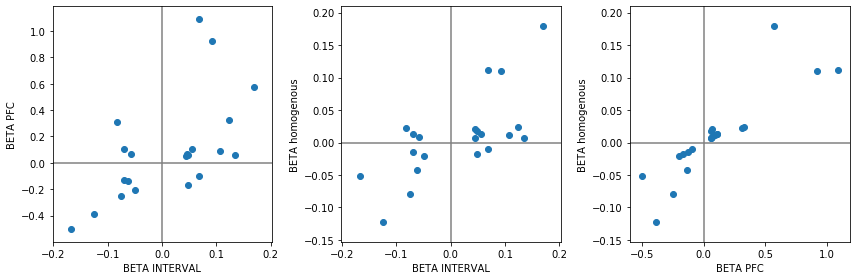

In [117]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
ax.scatter(mix["BETA_INTERVAL_PFC_convention"],mix["BETA_PFC"])
ax.set_xlabel("BETA INTERVAL")
ax.set_ylabel("BETA PFC")
ax.axvline(0,c="grey")
ax.axhline(0,c="grey")
ax = fig.add_subplot(132)
ax.scatter(mix["BETA_INTERVAL_PFC_convention"],mix["homogenous_BETA"])
ax.set_xlabel("BETA INTERVAL")
ax.set_ylabel("BETA homogenous")
ax.axvline(0,c="grey")
ax.axhline(0,c="grey")
ax = fig.add_subplot(133)
ax.scatter(mix["BETA_PFC"],mix["homogenous_BETA"])
ax.set_xlabel("BETA PFC")
ax.set_ylabel("BETA homogenous")
ax.axvline(0,c="grey")
ax.axhline(0,c="grey")
plt.tight_layout()

In [118]:
mix.shape

(21, 41)

In [120]:
mix.sort_values(["CHR_PFC","POS_PFC"])[["RSID_PFC","ALT_PFC","ALLELE1_INTERVAL","proxy_for","BETA_PFC","BETA_INTERVAL_PFC_convention","homogenous_BETA","COUNTED_IN_UKB"]]

,RSID_PFC,ALT_PFC,ALLELE1_INTERVAL,proxy_for,BETA_PFC,BETA_INTERVAL_PFC_convention,homogenous_BETA,COUNTED_IN_UKB
9,rs12566888,T,G,rs12566888,-0.39070,-0.124800,-0.122545,T
10,rs1434282,T,C,rs1434282,-0.12670,-0.069544,-0.015204,T
11,rs41315846,C,T,rs41315846,-0.20240,-0.049249,-0.020602,C
12,rs13412535,A,G,rs13412535,0.06930,-0.057557,0.008316,A
13,rs78909033,A,G,rs78909033,0.10420,-0.069758,0.012504,A
16,rs1354034,C,T,rs1354034,-0.25290,-0.074894,-0.079323,C
14,rs13067286,A,G,rs13067286,-0.16860,0.047616,-0.017162,A
15,rs76445378,T,C,rs76445378,-0.50330,-0.167710,-0.051231,T
17,rs922140,G,A,rs922140,-0.09618,0.068151,-0.009790,G
18,rs17881225,C,G,rs3819288,0.31080,-0.082018,0.022964,C


## Export scores

In [121]:
interval_SNPs = bolt.SNP.tolist()
pfc_SNPs  = mix.RSID_PFC.tolist()

In [255]:
len(pfc_SNPs)

21

In [256]:
len(interval_SNPs)

21

In [254]:
G[pfc_SNPs].isnull().mean(axis=0)

SNP
rs10886430    0.0
rs7123827     0.0
rs11553699    0.0
rs61978213    0.0
rs12905925    0.0
rs12445050    0.0
rs8057254     0.0
rs11078475    0.0
rs1654425     0.0
rs12566888    0.0
rs1434282     0.0
rs41315846    0.0
rs13412535    0.0
rs78909033    0.0
rs13067286    0.0
rs76445378    0.0
rs1354034     0.0
rs922140      0.0
rs17881225    0.0
rs61751937    0.0
rs55665228    0.0
dtype: float64

In [123]:
# Checked that counted allele is the opposite of interval effect allele
interval_score = G[pfc_SNPs] @ mix.set_index("RSID_PFC").loc[pfc_SNPs,"BETA_INTERVAL_PFC_convention"]

In [124]:
# Checked that in PFC, effect allele is the opposite as in interval, hence the same as the counted allele
# adp_score = G[pfc_SNPs] @ mix.set_index("SNP").loc[pfc_SNPs,"BETA_ADP"]
best_pval_score = G[pfc_SNPs] @ mix.set_index("RSID_PFC").loc[pfc_SNPs,"BETA_PFC"]
best_pval_score_homogenous = G[pfc_SNPs] @ mix.set_index("RSID_PFC").loc[pfc_SNPs,"homogenous_BETA"]

In [125]:
to_export = pd.DataFrame(index=interval_score.index)
to_export["INTERVAL_score"] = interval_score
to_export["best_pval_score"] = best_pval_score
to_export["best_pval_score_homogenous"] = best_pval_score_homogenous

In [129]:
means = to_export[["INTERVAL_score","best_pval_score","best_pval_score_homogenous"]].mean(axis=0)
stds = to_export[["INTERVAL_score","best_pval_score","best_pval_score_homogenous"]].std(axis=0)
print(means)
print(stds)

INTERVAL_score                0.162051
best_pval_score               1.116968
best_pval_score_homogenous    0.074326
dtype: float64
INTERVAL_score                0.182967
best_pval_score               0.811181
best_pval_score_homogenous    0.123581
dtype: float64


In [130]:
to_export[["INTERVAL_score","best_pval_score","best_pval_score_homogenous"]] -= means
to_export[["INTERVAL_score","best_pval_score","best_pval_score_homogenous"]] /= stds

In [131]:
to_export.to_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder,key="scores")

## Export Mix table

In [127]:
print(mix.shape[0])

21


In [132]:
export_folder

'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing'

In [237]:
mix_nice = mix.sort_values(["CHR_PFC","POS_PFC"])[["RSID_PFC","ALT_PFC","ALLELE1_INTERVAL","proxy_for","BETA_PFC","BETA_INTERVAL_PFC_convention","homogenous_BETA","SE_INTERVAL","homogenous_SE","COUNTED_IN_UKB","best_agonist_PFC"]]
mix_nice["homogenous_BETA_scaled"] = mix_nice["homogenous_BETA"] / stds.loc["best_pval_score_homogenous"]
mix_nice["INTERVAL_BETA_PFC_convention_scaled"] = mix_nice["BETA_INTERVAL_PFC_convention"] / stds.loc["INTERVAL_score"]
mix_nice["INTERVAL_BETA_PFC_convention_scaled_old"] = mix_nice["BETA_INTERVAL_PFC_convention"] / stds.loc["best_pval_score_homogenous"]
mix_nice["homogenous_SE_scaled"] = mix_nice["homogenous_SE"] / stds.loc["best_pval_score_homogenous"]
mix_nice["INTERVAL_SE_scaled"] = mix_nice["SE_INTERVAL"] / stds.loc["INTERVAL_score"]

In [238]:
mix.to_csv("%s/PFC_INTERVAL_comparison_with_proxies.csv" % export_folder)
mix_nice.to_csv("/home/hv270/sysmex2pf/supplementary_tables/PFC_INTERVAL_comparison_with_proxies.csv")

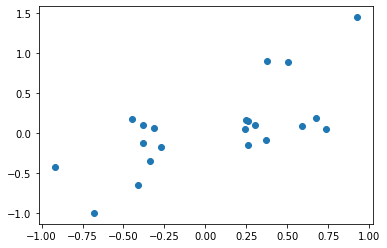

In [239]:
plt.scatter(mix_nice["INTERVAL_BETA_PFC_convention_scaled"],mix_nice["homogenous_BETA_scaled"])

# Supplementary table comparing INTERVAL and PFC

In [240]:
mix = pd.read_csv("%s/PFC_INTERVAL_comparison_with_proxies.csv" % export_folder,index_col=0)

In [241]:
mix.loc[mix.ALLELE1_INTERVAL != mix.ALT_PFC,"BETA_INTERVAL"] *=- 1

In [242]:
mix.sort_values(["CHR_PFC","BP_PFC"])[["BETA_INTERVAL"]]

,BETA_INTERVAL
9,-0.124800
10,-0.069544
11,-0.049249
12,-0.057557
13,-0.069758
16,-0.074894
14,0.047616
15,-0.167710
17,0.068151
18,-0.082018


# Plot

## Read exported scores

In [243]:
scores = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder,key="scores")
mix = pd.read_csv("%s/PFC_INTERVAL_comparison_with_proxies.csv" % export_folder,index_col=0)
score_std = scores["best_pval_score_homogenous"].std()
replacement = {'rs3819288': 'rs17881225', 'rs59001897': 'rs12905925'}

In [244]:
gwas_results[[c for c in gwas_results.columns if c not in mix.columns] + ["SNP"]]

,CHR,BP,A1_INTERVAL,P_INTERVAL,SYMBOL,SNP
0,1,156869047,G,1.200000e-24,PEAR1,rs12566888
1,1,199010721,C,8.300000e-18,RP11-16L9.4,rs1434282
2,1,247712303,T,9.200000e-12,OR2C3,rs41315846
3,2,224874874,G,3.200000e-10,SERPINE2,rs13412535
4,2,241510903,G,2.000000e-11,ANKMY1,rs78909033
5,3,56849749,T,6.200000e-25,ARHGEF3,rs1354034
6,3,124340093,G,1.900000e-11,UMPS,rs13067286
7,3,124366890,C,2.800000e-09,UMPS,rs76445378
8,5,122088890,A,6.600000e-21,SNX2,rs922140
9,6,31322694,T,7.100000e-13,HLA-B,rs3819288


In [245]:
comp = mix_nice.copy().replace({"ADP_META":"ADP","CRP":"CRP-XL"})

comp = pd.merge(comp,gwas_results[[c for c in gwas_results.columns if c not in mix.columns] + ["SNP"]],left_on="proxy_for",right_on="SNP",how="left")
#comp = comp.merge(bg[["SNP","SE"]].rename(columns={"SE":"SE_INTERVAL"}),left_on="SNP",right_on="SNP")
comp = comp.replace({"OR2C3":"GCSAML"})

In [246]:
comp

,RSID_PFC,ALT_PFC,ALLELE1_INTERVAL,proxy_for,BETA_PFC,BETA_INTERVAL_PFC_convention,homogenous_BETA,SE_INTERVAL,homogenous_SE,COUNTED_IN_UKB,...,INTERVAL_BETA_PFC_convention_scaled,INTERVAL_BETA_PFC_convention_scaled_old,homogenous_SE_scaled,INTERVAL_SE_scaled,CHR,BP,A1_INTERVAL,P_INTERVAL,SYMBOL,SNP
0,rs12566888,T,G,rs12566888,-0.39070,-0.124800,-0.122545,0.012343,0.022157,T,...,-0.682089,-1.009866,0.179289,0.067462,1,156869047,G,1.200000e-24,PEAR1,rs12566888
1,rs1434282,T,C,rs1434282,-0.12670,-0.069544,-0.015204,0.008183,0.005347,T,...,-0.380090,-0.562742,0.043268,0.044724,1,199010721,C,8.300000e-18,RP11-16L9.4,rs1434282
2,rs41315846,C,T,rs41315846,-0.20240,-0.049249,-0.020602,0.007291,0.006288,C,...,-0.269169,-0.398518,0.050878,0.039851,1,247712303,T,9.200000e-12,GCSAML,rs41315846
3,rs13412535,A,G,rs13412535,0.06930,-0.057557,0.008316,0.009069,0.005430,A,...,-0.314578,-0.465748,0.043938,0.049565,2,224874874,G,3.200000e-10,SERPINE2,rs13412535
4,rs78909033,A,G,rs78909033,0.10420,-0.069758,0.012504,0.010456,0.006801,A,...,-0.381259,-0.564473,0.055036,0.057145,2,241510903,G,2.000000e-11,ANKMY1,rs78909033
5,rs1354034,C,T,rs1354034,-0.25290,-0.074894,-0.079323,0.007310,0.012703,C,...,-0.409329,-0.606032,0.102791,0.039950,3,56849749,T,6.200000e-25,ARHGEF3,rs1354034
6,rs13067286,A,G,rs13067286,-0.16860,0.047616,-0.017162,0.007114,0.006103,A,...,0.260241,0.385300,0.049387,0.038881,3,124340093,G,1.900000e-11,UMPS,rs13067286
7,rs76445378,T,C,rs76445378,-0.50330,-0.167710,-0.051231,0.028799,0.029611,T,...,-0.916612,-1.357088,0.239606,0.157400,3,124366890,C,2.800000e-09,UMPS,rs76445378
8,rs922140,G,A,rs922140,-0.09618,0.068151,-0.009790,0.007295,0.006431,G,...,0.372474,0.551465,0.052040,0.039868,5,122088890,A,6.600000e-21,SNX2,rs922140
9,rs17881225,C,G,rs3819288,0.31080,-0.082018,0.022964,0.011765,0.007370,C,...,-0.448265,-0.663678,0.059638,0.064300,6,31322694,T,7.100000e-13,HLA-B,rs3819288


In [247]:
#comp_read = pd.read_hdf("%s/comp_fig3a.hdf" % export_folder)

In [248]:
#comp.loc[comp.RSID_PFC == "rs12566888"]

In [249]:
comp.to_hdf("%s/comp_fig3a.hdf" % export_folder,key="comp")

## Start from pre-processed table

In [250]:
from matplotlib.patches import Ellipse
from scipy.stats import pearsonr

In [251]:
comp = pd.read_hdf("%s/comp_fig3a.hdf" % export_folder)\
    .replace({"RP11-16L9.4":"PTPRC",
              "OR2C3":"GCSAML",
              "ANKMY1":"RNPEPL1",
              "MRVI1":"IRAG1",
              "SVEP1":"SVEP1",
              "UMPS":"KALRN",
              "PIF1":"PLEKHO2",
              "TMEM120B":"RHOF"})
comp.to_csv("/home/hv270/sysmex2pf/figures/betas_info.csv")

In [252]:
comp.head()

,RSID_PFC,ALT_PFC,ALLELE1_INTERVAL,proxy_for,BETA_PFC,BETA_INTERVAL_PFC_convention,homogenous_BETA,SE_INTERVAL,homogenous_SE,COUNTED_IN_UKB,...,INTERVAL_BETA_PFC_convention_scaled,INTERVAL_BETA_PFC_convention_scaled_old,homogenous_SE_scaled,INTERVAL_SE_scaled,CHR,BP,A1_INTERVAL,P_INTERVAL,SYMBOL,SNP
0,rs12566888,T,G,rs12566888,-0.3907,-0.124800,-0.122545,0.012343,0.022157,T,...,-0.682089,-1.009866,0.179289,0.067462,1,156869047,G,1.200000e-24,PEAR1,rs12566888
1,rs1434282,T,C,rs1434282,-0.1267,-0.069544,-0.015204,0.008183,0.005347,T,...,-0.380090,-0.562742,0.043268,0.044724,1,199010721,C,8.300000e-18,PTPRC,rs1434282
2,rs41315846,C,T,rs41315846,-0.2024,-0.049249,-0.020602,0.007291,0.006288,C,...,-0.269169,-0.398518,0.050878,0.039851,1,247712303,T,9.200000e-12,GCSAML,rs41315846
3,rs13412535,A,G,rs13412535,0.0693,-0.057557,0.008316,0.009069,0.005430,A,...,-0.314578,-0.465748,0.043938,0.049565,2,224874874,G,3.200000e-10,SERPINE2,rs13412535
4,rs78909033,A,G,rs78909033,0.1042,-0.069758,0.012504,0.010456,0.006801,A,...,-0.381259,-0.564473,0.055036,0.057145,2,241510903,G,2.000000e-11,RNPEPL1,rs78909033


In [253]:
pearsonr(comp["INTERVAL_BETA_PFC_convention_scaled"],comp["homogenous_BETA_scaled"])

(0.6884931760933627, 0.000559046676930027)

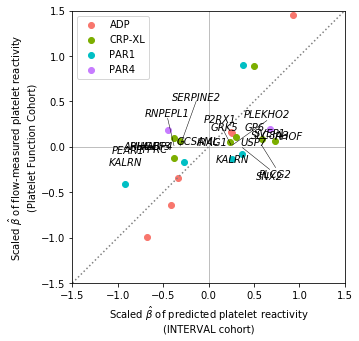

In [220]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'},figsize=(5,5))

ax.axvline(0,ls='-',c="grey",lw=.5)
ax.axhline(0,ls='-',c="grey",lw=.5)
ax.plot([-1.5,1.5],[-1.5,1.5],ls=":",c="grey")

colors = {"ADP":"#F8766D","CRP-XL":"#7CAE00","PAR1":"#00BFC4","PAR4":"#C77CFF"}
for i, (ago, comp_) in enumerate(comp.groupby("best_agonist_PFC")):
    ax.scatter(comp_["INTERVAL_BETA_PFC_convention_scaled"],comp_["homogenous_BETA_scaled"],c=colors[ago],label=ago)
ax.legend()


known_genes = ["GP6","PEAR1","IRAG1","GRK5","ARHGEF3","SVEP1"]

shifts = {"GRK5":(-.2,0.02),
          "SVEP1":(-.25,-0.12),
         "GP6":(0.,0.02),
         "HLA-B":(-0.25,-.1),
         "SLC8A3":(0.,0.02),
         "PTPRC":(-.25,-.1),
          "HABP4":(-.23,-0.04),
          "PLCG2":(.15,-.4),
          "KALRN":(.0,-0.2),
          "GCSAML":(.15,0.),
          "RHOF":(.15,.02),
          "SERPINE2":(.18,0.45),
          "SNX2":(.3,-.4),
          "P2RX1":(-.12,0.2),
          "PLEKHO2":(0.38,.25),
          "USP7":(0.19,-.05),
          "IRAG1":(-.2,-.04),
          "ARHGEF3":(-.26,0.),
          "PEAR1":(-.2,0.),
         "RNPEPL1":(-.07,.27)}

to_link = ["RNPEPL1","SERPINE2","PLCG2","SNX2","P2RX1","PLEKHO2"]
link_shift = {"GCSAML":(-.24,.05),
              "SERPINE2":(0.,0.0),
              "P2RX1":(0.,-.02),
              "RNPEPL1":(0.,-0.02),"PLEKHO2":(.0,-0.03)}
for i, row in comp.iterrows():
    
    #ax.add_artist(ells[i])
    ells[i].set_clip_box(ax.bbox)
    ells[i].set_alpha(.5)
    ago = row["best_agonist_PFC"]
    ells[i].set_facecolor(colors[ago])
    ells[i].set_edgecolor(colors[ago])
    #weight = "bold" if row["SYMBOL"] in known_genes else None
    weight = None
    if row["SYMBOL"] in shifts:
        shift_x,shift_y = shifts[row["SYMBOL"]]
    else:
        shift_x,shift_y = 0,0
    if row["SYMBOL"] == "KALRN" and i == 15:
        shift_x,shift_y = 0.1,0.02
    ax.text(row["INTERVAL_BETA_PFC_convention_scaled"]+shift_x,
            .05+row["homogenous_BETA"]+shift_y,row["SYMBOL"],
            ha="center",style="italic",weight=weight)
    if row["SYMBOL"] in to_link:
        shift_x_link, shift_y_link = 0., .11 
        if row["SYMBOL"] in link_shift:
            shift_x_link, shift_y_link = link_shift[row["SYMBOL"]]
        ax.plot([row["INTERVAL_BETA_PFC_convention_scaled"],
                 row["INTERVAL_BETA_PFC_convention_scaled"]+shift_x+shift_x_link],
                [row["homogenous_BETA"],.05+row["homogenous_BETA"]+shift_y+shift_y_link],lw=.5,c="black")
    
ax.set_xlabel("Scaled $\hat{\\beta}$ of predicted platelet reactivity \n(INTERVAL cohort)")
ax.set_ylabel("Scaled $\hat{\\beta}$ of flow-measured platelet reactivity\n(Platelet Function Cohort)")

ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/betas.pdf")

In [221]:
pip install networkx

     |████████████████████████████████| 1.9MB 7.8MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


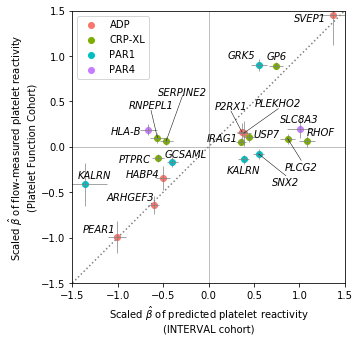

In [16]:
ells = {}
for i, row in comp.iterrows():
    ells[i] = Ellipse(xy=np.array([row["BETA_INTERVAL"],row["homogenous_BETA"]]),
                  angle = 0.,
                  width=row["SE_INTERVAL"],height=-1*row["homogenous_SE"])

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'},figsize=(5,5))

ax.axvline(0,ls='-',c="grey",lw=.5)
ax.axhline(0,ls='-',c="grey",lw=.5)
ax.plot([-1.5,1.5],[-1.5,1.5],ls=":",c="grey")

colors = {"ADP":"#F8766D","CRP-XL":"#7CAE00","PAR1":"#00BFC4","PAR4":"#C77CFF"}
for i, (ago, comp_) in enumerate(comp.groupby("best_agonist_PFC")):
    ax.scatter(comp_["BETA_INTERVAL"],comp_["homogenous_BETA"],c=colors[ago],label=ago)
    ax.errorbar(comp_["BETA_INTERVAL"],comp_["homogenous_BETA"],
                elinewidth=.7,
                c="grey",
                #els=":",
                ls='none',
                xerr=comp_["SE_INTERVAL"],
                yerr=comp_["homogenous_SE"])
ax.legend()


known_genes = ["GP6","PEAR1","IRAG1","GRK5","ARHGEF3","SVEP1"]

shifts = {"GRK5":(-.2,0.02),
          "SVEP1":(-.25,-0.12),
         "GP6":(0.,0.02),
         "HLA-B":(-0.25,-.1),
         "SLC8A3":(0.,0.02),
         "PTPRC":(-.25,-.1),
          "HABP4":(-.23,-0.04),
          "PLCG2":(.15,-.4),
          "KALRN":(.0,-0.2),
          "GCSAML":(.15,0.),
          "RHOF":(.15,.02),
          "SERPINE2":(.18,0.45),
          "SNX2":(.3,-.4),
          "P2RX1":(-.12,0.2),
          "PLEKHO2":(0.38,.25),
          "USP7":(0.19,-.05),
          "IRAG1":(-.2,-.04),
          "ARHGEF3":(-.26,0.),
          "PEAR1":(-.2,0.),
         "RNPEPL1":(-.07,.27)}

to_link = ["RNPEPL1","SERPINE2","PLCG2","SNX2","P2RX1","PLEKHO2"]
link_shift = {"GCSAML":(-.24,.05),
              "SERPINE2":(0.,0.0),
              "P2RX1":(0.,-.02),
              "RNPEPL1":(0.,-0.02),"PLEKHO2":(.0,-0.03)}
for i, row in comp.iterrows():
    
    #ax.add_artist(ells[i])
    ells[i].set_clip_box(ax.bbox)
    ells[i].set_alpha(.5)
    ago = row["best_agonist_PFC"]
    ells[i].set_facecolor(colors[ago])
    ells[i].set_edgecolor(colors[ago])
    #weight = "bold" if row["SYMBOL"] in known_genes else None
    weight = None
    if row["SYMBOL"] in shifts:
        shift_x,shift_y = shifts[row["SYMBOL"]]
    else:
        shift_x,shift_y = 0,0
    if row["SYMBOL"] == "KALRN" and i == 15:
        shift_x,shift_y = 0.1,0.02
    ax.text(row["BETA_INTERVAL"]+shift_x,
            .05+row["homogenous_BETA"]+shift_y,row["SYMBOL"],
            ha="center",style="italic",weight=weight)
    if row["SYMBOL"] in to_link:
        shift_x_link, shift_y_link = 0., .11 
        if row["SYMBOL"] in link_shift:
            shift_x_link, shift_y_link = link_shift[row["SYMBOL"]]
        ax.plot([row["BETA_INTERVAL"],row["BETA_INTERVAL"]+shift_x+shift_x_link],
                [row["homogenous_BETA"],.05+row["homogenous_BETA"]+shift_y+shift_y_link],lw=.5,c="black")
    
ax.set_xlabel("Scaled $\hat{\\beta}$ of predicted platelet reactivity \n(INTERVAL cohort)")
ax.set_ylabel("Scaled $\hat{\\beta}$ of flow-measured platelet reactivity\n(Platelet Function Cohort)")

ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/betas_err.pdf")

In [ ]:
## PREVIOUS VERSION, JUST IN CASE...

ells = {}
for i, row in comp.iterrows():
    ells[i] = Ellipse(xy=np.array([row["BETA_INTERVAL"],row["homogenous_BETA"]]),
                  angle = 0.,
                  width=row["SE_INTERVAL"],height=-1*row["homogenous_SE"])

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'},figsize=(5,5))

ax.axvline(0,ls='-',c="grey",lw=.5)
ax.axhline(0,ls='-',c="grey",lw=.5)
ax.plot([-1.5,1.5],[-1.5,1.5],ls=":",c="grey")

colors = {"ADP":"#F8766D","CRP-XL":"#7CAE00","PAR1":"#00BFC4","PAR4":"#C77CFF"}
for i, (ago, comp_) in enumerate(comp.groupby("best_agonist_PFC")):
    ax.scatter(comp_["BETA_INTERVAL"],comp_["homogenous_BETA"],c=colors[ago],label=ago)
ax.legend()


known_genes = ["GP6","PEAR1","IRAG1","GRK5","ARHGEF3","SVEP1"]

shifts = {"GRK5":(.1,0.04),
          "SVEP1":(.3,0),
         "GP6":(0.,-.23),
         "HLA-B":(0.25,-.1),
         "SLC8A3":(-.25,-.25),
         "PTPRC":(.25,-.1),
          "HABP4":(.4,0.),
          "PLCG2":(-.1,-.5),
          "KALRN":(-.05,0.),
          "GCSAML":(.5,0.),
          "RHOF":(.0,.04),
          "SERPINE2":(-.15,-.4),
          "SNX2":(-.3,.4),
          "P2RX1":(0.12,-.4),
          "PLEKHO2":(-0.17,-.25),
          "USP7":(-0.22,-.17),
          "IRAG1":(.16,0.37),
          "ARHGEF3":(-.26,0.),
          "PEAR1":(-.2,0.),
         "RNPEPL1":(.05,-.55)}

to_link = ["RNPEPL1","SERPINE2","GCSAML","HABP4","PLCG2","SNX2","P2RX1","PLEKHO2","USP7","SLC8A3","IRAG1"]
link_shift = {"GCSAML":(-.24,.05),"HABP4":(-.2,.05),"SNX2":(0.,-.01),"IRAG1":(.1,-.02),"PLEKHO2":(.1,0.1)}
for i, row in comp.iterrows():
    
    #ax.add_artist(ells[i])
    ells[i].set_clip_box(ax.bbox)
    ells[i].set_alpha(.5)
    ago = row["best_agonist_PFC"]
    ells[i].set_facecolor(colors[ago])
    ells[i].set_edgecolor(colors[ago])
    #weight = "bold" if row["SYMBOL"] in known_genes else None
    weight = None
    if row["SYMBOL"] in shifts:
        shift_x,shift_y = shifts[row["SYMBOL"]]
    else:
        shift_x,shift_y = 0,0
    ax.text(row["BETA_INTERVAL"]+shift_x,
            .05+row["homogenous_BETA"]+shift_y,row["SYMBOL"],
            ha="center",style="italic",weight=weight)
    if row["SYMBOL"] in to_link:
        shift_x_link, shift_y_link = 0., .11 
        if row["SYMBOL"] in link_shift:
            shift_x_link, shift_y_link = link_shift[row["SYMBOL"]]
        ax.plot([row["BETA_INTERVAL"],row["BETA_INTERVAL"]+shift_x+shift_x_link],
                [row["homogenous_BETA"],.05+row["homogenous_BETA"]+shift_y+shift_y_link],lw=.5,c="black")
    
ax.set_xlabel("Scaled $\hat{\\beta}$ of predicted platelet reactivity \n(INTERVAL cohort)")
ax.set_ylabel("Scaled $\hat{\\beta}$ of flow-measured platelet reactivity\n(Platelet Function Cohort)")

ax.set_xlim((-1.5,1.5))
ax.set_ylim((-1.5,1.5))
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/betas.pdf")

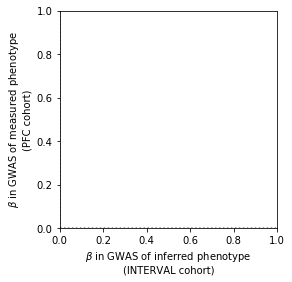

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse


# Fixing random state for reproducibility
np.random.seed(19680801)

NUM = 250

ells = [Ellipse(xy=np.array([row["BETA_INTERVAL"],row["homogenous_BETA"]]),#np.random.rand(2) * 10,
                angle = 0.,
                width=1.,height=row["homogenous_SE"])
        for i, row in comp.iterrows()]

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(np.random.rand())
    e.set_facecolor(np.random.rand(3))
    
ax.set_xlabel("$\\beta$ in GWAS of inferred phenotype\n(INTERVAL cohort)")
ax.set_ylabel("$\\beta$ in GWAS of measured phenotype\n(PFC cohort)")
ax.axvline(0,ls=':',c="grey")
ax.axhline(0,ls=':',c="grey")

plt.show()

In [188]:
comp[["best_p_val_agonist"]].replace({"ADP_META":"ADP"})

,best_p_val_agonist
0,ADP
1,ADP
2,ADP
3,PAR1
4,ADP
5,PAR4
6,CRP
7,ADP
8,PAR4
9,CRP


# WHAT IS BELOW IS UNUSED IN THE FINAL PAPER

In [113]:
X = G_merged.values

In [114]:
X = X - np.mean(X,axis=0)

In [115]:
X /= np.std(X,axis=0)

In [116]:
N = X.shape[0]

In [117]:
C = (1./N) * (X.T @ X)

In [118]:
np.fill_diagonal(C,0.)

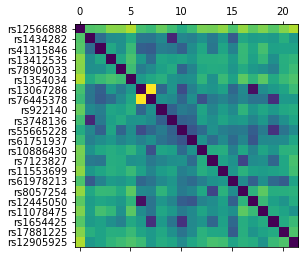

In [119]:
plt.matshow(np.log10(1e-4+np.abs(C)))
plt.yticks(np.arange(C.shape[0]),G_merged.columns);

(array([ 22.,   0.,   0.,   0.,   2.,  10.,  78., 230., 124.,  18.]),
 array([-7.        , -6.38976996, -5.77953993, -5.16930989, -4.55907986,
        -3.94884982, -3.33861979, -2.72838975, -2.11815971, -1.50792968,
        -0.89769964]),
 <a list of 10 Patch objects>)

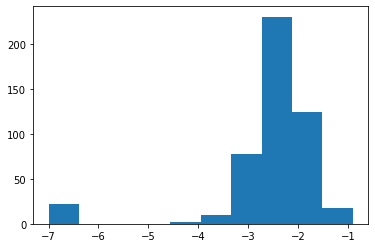

In [120]:
plt.hist(np.log10(1e-7 + np.abs(np.reshape(C,(-1,)))))

# Build score based on Top-22 Dragana's hits

## Export hits

In [174]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])]
dgw.rename(columns={'(UNIVAR) -log10 P':"MLOG10P"},inplace=True)

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [181]:
dgw.columns

Index(['Associated Blood Index', 'Novel vs Astle 2016', 'Locus ID',
       'Associated Blood Index Class', 'Unique Variant ID', 'Gene', 'SNP',
       'INFO SCORE', 'Chr (GRCh37)', 'BP (GRCh37)', 'REF (GRC37)',
       'ALT (GRC37)', 'Minor Allele', 'Alternative Allele Frequency',
       'Minor Allele Frequency',
       '(UNIVAR) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)',
       '(UNIVAR) Standard Error of Estimator', 'MLOG10P',
       '(UNIVAR) Unadjusted R2',
       '(MULTI) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)',
       '(MULTI) Standard Error of Estimate', '(MULTI) -log10 P',
       'Most Serious VEP Consequence of Variant',
       'VEP IMPACT of Most Serious Consequence',
       'Ensembl Gene ID(s) for Most Serious Consequence'],
      dtype='object')

In [219]:
top_draganas = dgw.loc[dgw["Minor Allele Frequency"] >= 0.01].sort_values("MLOG10P",ascending=False).groupby("SNP")[["Gene","Minor Allele Frequency","MLOG10P","Unique Variant ID"]].first().sort_values("MLOG10P",ascending=False).head(22)

In [220]:
top_draganas

,Gene,Minor Allele Frequency,MLOG10P,Unique Variant ID
SNP,,,,
rs11553699,"TMEM120B,RHOF",0.129690,3154.750012,12:122216910_A_G
rs463312,TUBB1,0.048016,2679.090323,20:57597970_A_C
rs1354034,ARHGEF3,0.395519,2579.524602,3:56849749_T_C
rs342293,CTB-111H14.1,0.454961,1413.487193,7:106372219_C_G
rs517967,TAOK1,0.485971,973.024590,17:27794988_T_G
rs6425522,DNM3,0.198844,802.923537,1:171946082_T_C
rs10761731,JMJD1C,0.419837,799.464216,10:65027610_A_T
rs78909033,RNPEPL1,0.135614,768.255237,2:241510903_G_A
rs9402686,HBS1L,0.271464,712.914670,6:135427817_G_A


In [221]:
dgw_pfc = pd.merge(top_draganas,pfc,left_on="Unique Variant ID",right_on="ID",suffixes=("_DGW","_PFC"),how="left")

In [222]:
dgw_pfc

,Gene,Minor Allele Frequency,MLOG10P_DGW,Unique Variant ID,ID,RSID,CHR,POS,REF,ALT,...,ALT_MINOR,REF_COUNT,ALT_COUNT,INFO,BETA,SE,MLOG10P_PFC,hit_rank,BP,SNP
0,"TMEM120B,RHOF",0.129690,3154.750012,12:122216910_A_G,12:122216910_A_G,rs11553699,12,122216910,A,G,...,True,4758.2,733.8,0.8877,-0.037110,0.06418,0.24940,4249526,122216910.0,rs11553699
1,TUBB1,0.048016,2679.090323,20:57597970_A_C,20:57597970_A_C,rs463312,20,57597970,A,C,...,True,5242.0,250.0,1.0000,0.002972,0.09512,0.01096,7305326,NaN,rs463312
2,ARHGEF3,0.395519,2579.524602,3:56849749_T_C,3:56849749_T_C,rs1354034,3,56849749,T,C,...,False,2114.0,3378.0,1.0000,-0.252900,0.04050,9.37400,1,56849749.0,rs1354034
3,CTB-111H14.1,0.454961,1413.487193,7:106372219_C_G,7:106372219_C_G,rs342293,7,106372219,C,G,...,True,3080.0,2412.0,1.0000,0.025660,0.04213,0.26570,4094661,NaN,rs342293
4,TAOK1,0.485971,973.024590,17:27794988_T_G,17:27794988_T_G,rs517967,17,27794988,T,G,...,False,2680.7,2811.3,0.9982,0.031770,0.04056,0.36310,3280798,NaN,rs517967
5,DNM3,0.198844,802.923537,1:171946082_T_C,1:171946082_T_C,rs6425522,1,171946082,T,C,...,False,1107.7,4384.3,0.9838,-0.066880,0.05064,0.72920,1430435,NaN,rs6425522
6,JMJD1C,0.419837,799.464216,10:65027610_A_T,10:65027610_A_T,rs71476393,10,65027610,A,T,...,True,3242.0,2250.0,1.0000,0.104900,0.04123,1.96100,86342,NaN,rs71476393
7,RNPEPL1,0.135614,768.255237,2:241510903_G_A,2:241510903_G_A,rs78909033,2,241510903,G,A,...,True,4740.0,752.0,1.0000,0.019190,0.05880,0.12830,5595561,241510903.0,rs78909033
8,HBS1L,0.271464,712.914670,6:135427817_G_A,6:135427817_G_A,rs9402686,6,135427817,G,A,...,True,4008.0,1484.0,1.0000,-0.014510,0.04578,0.12420,5648952,NaN,rs9402686
9,None,0.311369,683.883782,9:4763491_G_A,9:4763491_G_A,rs12005199,9,4763491,G,A,...,True,3715.5,1776.5,0.9110,0.020940,0.04537,0.19090,4851676,NaN,rs12005199


In [226]:
rsIDs = set(dgw_pfc.RSID.unique().tolist() + dgw_pfc.SNP.unique().tolist())
print(len(rsIDs))

22


In [227]:
dgw_snp_path = "%s/DGW_top_snps.txt" % (export_folder)
with open(dgw_snp_path,"w") as f:
    for snp in rsIDs:
        f.write("%s\n" % snp)

In [230]:
n_splits = 12
for chrom in dgw_pfc.CHR.unique().tolist():
    gen_path = "%s/UKB_DGW_SNPS_genotypes/chr_%d" % (export_folder, chrom)
    command = "/home/hv270/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    command += " --extract %s" % dgw_snp_path
    command += " --recode A-transpose --out %s" % gen_path
    
    f_name = "/home/hv270/interval_slurm_calls/call_beta_chr_%s_%s.sh" % (chrom,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=3:00:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("beta",tag,chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 12
Submitting 20
Submitting 3
Submitting 7
Submitting 17
Submitting 1
Submitting 10
Submitting 2
Submitting 6
Submitting 9
Submitting 5
Submitting 11


## Read and build score

In [21]:
dfs = []
for f in glob("%s/UKB_DGW_SNPS_genotypes/chr_*.traw" % export_folder):
    df = pd.read_csv(f,sep="\t")
    dfs.append(df)
df = pd.concat(dfs,axis=0)

KeyboardInterrupt: 

In [ ]:
IDs_cols = [c for c in df.columns if "_" in c]

In [ ]:
G_dgw = df.set_index("SNP")[IDs_cols].T

In [22]:
G_dgw

SNP,rs12005199,rs77265585,rs10974808,rs11604127,rs463312,rs1354034,rs9311623,rs655029,rs78909033,rs34592828,...,rs998908,rs3184504,rs11553699,rs2038479,rs6425522,rs1768584,rs511515,rs34164109,rs9402686,rs342293
3988147_3988147,1.00000,0.0,0.0,0.0000,0.0,1.0,1.0,2.00000,0.0,0.0,...,0.0,1.0,0.00000,2.0000,2.0,2.0,1.0,0.0,0.0,1.0
5152243_5152243,2.00000,1.0,1.0,0.0000,0.0,1.0,2.0,2.00000,0.0,0.0,...,1.0,1.0,0.94507,1.0000,1.0,1.0,1.0,0.0,0.0,2.0
2770265_2770265,0.00000,0.0,0.0,0.0000,0.0,2.0,2.0,1.00000,0.0,0.0,...,0.0,2.0,0.00000,1.0039,1.0,1.0,0.0,0.0,0.0,1.0
3790399_3790399,0.00000,0.0,0.0,0.9961,0.0,2.0,2.0,0.97644,0.0,0.0,...,1.0,0.0,0.18430,2.0000,2.0,1.0,0.0,1.0,1.0,2.0
4681935_4681935,1.00000,1.0,1.0,0.0000,0.0,0.0,1.0,1.00000,0.0,0.0,...,1.0,1.0,0.00000,2.0000,2.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4494916_4494916,1.95294,0.0,0.0,0.9961,0.0,1.0,1.0,1.99610,1.0,0.0,...,1.0,0.0,1.00390,1.0000,1.0,1.0,1.0,1.0,1.0,1.0
4272180_4272180,0.03530,0.0,1.0,0.0000,1.0,1.0,1.0,1.99210,0.0,0.0,...,0.0,2.0,1.12160,2.0000,2.0,1.0,1.0,0.0,0.0,0.0
2654475_2654475,0.00000,0.0,0.0,0.0000,0.0,2.0,2.0,1.00000,0.0,0.0,...,0.0,1.0,0.00000,2.0000,2.0,1.0,2.0,1.0,1.0,2.0
4943537_4943537,0.99210,0.0,0.0,0.9137,0.0,2.0,2.0,2.00000,0.0,0.0,...,0.0,2.0,1.00000,2.0000,2.0,0.0,2.0,0.0,0.0,0.0


In [23]:
dgw_betas = pfc.set_index("SNP").loc[G_dgw.columns,"BETA"]

(array([1., 1., 0., 0., 2., 4., 3., 7., 2., 1.]),
 array([-0.2529 , -0.21671, -0.18052, -0.14433, -0.10814, -0.07195,
        -0.03576,  0.00043,  0.03662,  0.07281,  0.109  ]),
 <a list of 10 Patch objects>)

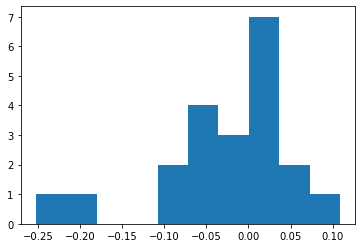

In [40]:
plt.hist(dgw_betas)

In [29]:
dgw_score = (2.-G_dgw) @ dgw_betas

# Re-Read PFC betas and compute scores

In [164]:
replaced_better = pd.merge(bolt.replace(replacement),pfc,how="left",left_on="SNP",right_on="SNP")
replaced_better = pd.merge(replaced_better, gwas_results[["SNP","CHR"]].replace(replacement),left_on="SNP",right_on="SNP",how="left")
replaced_better["BETA_merged"] = -replaced_better["BETA"]
missing = replaced_better.BETA_merged.isnull()
assert missing.sum() == 0

In [158]:
# missing : P2RX1, PLEKHO2, HLA-B & GP6
comp = pd.merge(bolt.replace(replacement),pfc,how="inner",left_on="SNP",right_on="SNP")
comp = pd.merge(comp, gwas_results[["SYMBOL","SNP","CHR"]].replace(replacement), left_on="SNP",right_on="SNP",how="left")

In [157]:
replacement

{'rs3819288': 'rs17881225', 'rs59001897': 'rs12905925'}

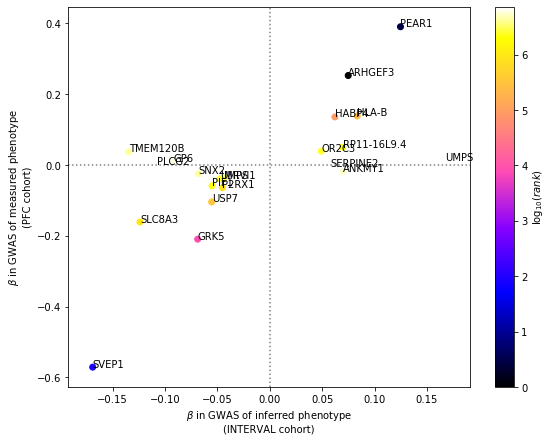

In [165]:
plt.figure(figsize=(9,7))
cm = plt.scatter(comp["ADP_pred"],-comp["BETA"],c=np.log10(comp["hit_rank"]),cmap="gnuplot2")
for i, row in comp.iterrows():
    if row["SYMBOL"]:
        plt.text(row["ADP_pred"],-row["BETA"],row["SYMBOL"])
plt.xlabel("$\\beta$ in GWAS of inferred phenotype\n(INTERVAL cohort)")
plt.ylabel("$\\beta$ in GWAS of measured phenotype\n(PFC cohort)")
plt.axvline(0,ls=':',c="grey")
plt.axhline(0,ls=':',c="grey")
plt.colorbar(cm,label="$\log_{10}(rank)$")

In [166]:
to_export = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder)

In [168]:
to_export.head()

SNP,rs12566888,rs1434282,rs41315846,rs13412535,rs78909033,rs1354034,rs13067286,rs76445378,rs922140,rs55665228,...,rs7123827,rs11553699,rs61978213,rs8057254,rs12445050,rs11078475,rs1654425,rs17881225,rs12905925,TOTAL
3988147_3988147,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.00000,...,1.0,0.00000,1.0,0.0,1.0,2.0,2.0,0.0,0.0,-0.162773
5152243_5152243,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.00000,...,0.0,0.94507,0.0,0.0,0.0,0.0,2.0,0.0,1.0,-0.172652
2770265_2770265,0.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,0.00000,...,2.0,0.00000,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-0.417057
3790399_3790399,1.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.03925,...,1.0,0.18430,0.0,0.0,0.0,2.0,2.0,0.0,0.0,-0.629205
4681935_4681935,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,...,2.0,0.00000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.399746


In [169]:
to_export["TOTAL_PFC"] = (2 - to_export[replaced_better.SNP.tolist()].values) @ replaced_better[["BETA_merged"]].values

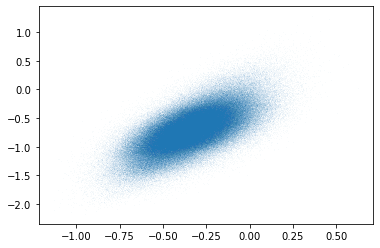

In [170]:
plt.scatter(to_export["TOTAL"],to_export["TOTAL_PFC"],s=.0001)

In [172]:
to_export[["TOTAL","TOTAL_PFC"]] -= to_export[["TOTAL","TOTAL_PFC"]].mean(axis=0)

In [173]:
to_export.to_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder, key="scores")

## Append DGW score to that

In [26]:
to_export = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder)

In [32]:
dgw_score_df = pd.DataFrame(dgw_score).rename(columns={0:"TOTAL_DGW"})

In [35]:
to_export = to_export.merge(dgw_score_df,left_index=True,right_index=True)

In [42]:
pearsonr(to_export["TOTAL_PFC"],to_export["TOTAL"])

(0.6679726703731929, 0.0)

In [41]:
pearsonr(to_export["TOTAL_PFC"],to_export["TOTAL_DGW"])

(-0.42775690080734524, 0.0)

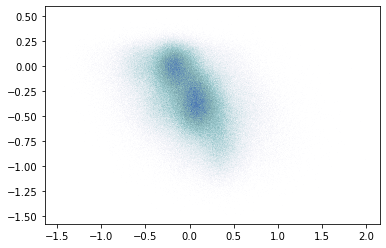

In [39]:
plt.scatter(to_export["TOTAL_PFC"],to_export["TOTAL_DGW"],s=.00001)

In [44]:
to_export

,rs12566888,rs1434282,rs41315846,rs13412535,rs78909033,rs1354034,rs13067286,rs76445378,rs922140,rs55665228,...,rs61978213,rs8057254,rs12445050,rs11078475,rs1654425,rs17881225,rs12905925,TOTAL,TOTAL_PFC,TOTAL_DGW
3988147_3988147,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.00000,...,1.0,0.0,1.0,2.0000,2.0,0.0,0.0,0.177452,0.098405,-0.617624
5152243_5152243,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.00000,...,0.0,0.0,0.0,0.0000,2.0,0.0,1.0,0.167572,0.322821,-0.424622
2770265_2770265,0.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,0.00000,...,0.0,0.0,0.0,1.0000,1.0,0.0,1.0,-0.076833,0.054766,-0.207040
3790399_3790399,1.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.03925,...,0.0,0.0,0.0,2.0000,2.0,0.0,0.0,-0.288981,-0.712958,-0.038376
4681935_4681935,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,...,0.0,0.0,0.0,1.0000,1.0,0.0,0.0,-0.059521,0.270382,-0.615097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4494916_4494916,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.00000,...,0.0,1.0,0.0,0.0000,2.0,1.0,1.0,0.074731,0.002584,-0.660736
4272180_4272180,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.00000,...,0.0,1.0,1.0,0.0000,2.0,0.0,0.0,0.235833,-0.104498,-0.428407
2654475_2654475,0.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,0.00000,...,0.0,0.0,2.0,2.0000,2.0,0.0,0.0,0.270606,-0.065664,0.011453
4943537_4943537,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.00000,...,0.0,0.0,0.0,0.9843,2.0,0.0,1.0,0.046543,-0.275658,0.102257


In [43]:
to_export.to_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder, key="scores")